#Introducing the Keras Sequential API

## taxi fare prediction - regression


https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/3_keras_sequential_api.ipynb


In [76]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

chown: invalid user: ‘jupyter:jupyter’


In [78]:
# Ensure the right version of Tensorflow is installed.
!pip freeze | grep tensorflow==2.1 || pip install tensorflow==2.1

tensorflow==2.1.0


## import libraries

In [79]:
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.callbacks import TensorBoard

print(tf.__version__)
%matplotlib inline

2.1.0


## load data

In [80]:
train_dataset_url = "https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/data/taxi-train.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /root/.keras/datasets/taxi-train.csv


### download csv files

In [81]:
# donwload csv datasset function

def download_csv( dataset_url ):

  dataset_fp = tf.keras.utils.get_file(fname=os.path.basename( dataset_url ),
                                           origin= dataset_url)
  print("Local copy of the dataset file: {}".format( dataset_fp ))
  return dataset_fp


In [82]:
tmp_url = "https://github.com/canislatranscoxus/tensorflow/blob/master/taxi-{}.csv"

# file paths
train_dataset_fp = download_csv( tmp_url.format( 'train' ) )
valid_dataset_fp = download_csv( tmp_url.format( 'valid' ) )
test_dataset_fp  = download_csv( tmp_url.format( 'test'  ) )


Local copy of the dataset file: /root/.keras/datasets/taxi-train.csv
Local copy of the dataset file: /root/.keras/datasets/taxi-valid.csv
Local copy of the dataset file: /root/.keras/datasets/taxi-test.csv


In [86]:
!rm /root/.keras/datasets/*.csv

In [87]:
!ls -l /root/.keras/datasets/*.csv

ls: cannot access '/root/.keras/datasets/*.csv': No such file or directory


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!more /root/.keras/datasets/taxi-train.csv

In [89]:
from google.colab import files
uploaded = files.upload()

Saving taxi-test.csv to taxi-test.csv
Saving taxi-train.csv to taxi-train.csv
Saving taxi-valid.csv to taxi-valid.csv


In [100]:
!pwd
!ls -l

/content
total 820
drwxr-xr-x 1 root root   4096 Aug 27 16:39 sample_data
-rw-r--r-- 1 root root 123589 Sep  3 23:10 taxi-test.csv
-rw-r--r-- 1 root root 579054 Sep  3 23:10 taxi-train.csv
-rw-r--r-- 1 root root 123113 Sep  3 23:11 taxi-valid.csv


In [101]:
train_dataset_fp = '/content/taxi-train.csv'
valid_dataset_fp = '/content/taxi-valid.csv'
test_dataset_fp  = '/content/taxi-test.csv'

##remove unwanted columns

In [102]:
CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key'
]
LABEL_COLUMN = 'fare_amount'
DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]
UNWANTED_COLS = ['pickup_datetime', 'key']

In [103]:
def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data
    
    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


In [104]:
def create_dataset(pattern, batch_size=1, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS)

    dataset = dataset.map(features_and_labels)

    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

## crate features

In [105]:
INPUT_COLS = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
]

# Create input layer of feature columns
# TODO 1
feature_columns = {
    colname: tf.feature_column.numeric_column(colname)
    for colname in INPUT_COLS
    }

## crate model

In [106]:
# Build a keras DNN model using Sequential API
# TODO 2a
model = Sequential([
    DenseFeatures(feature_columns=feature_columns.values()),
    Dense(units = 32, activation = "relu"  , name= "h1"     ),
    Dense(units =  8, activation = "relu"  , name= "h2"     ),
    Dense(units =  1, activation = "linear", name= "output" )
    ])

In [107]:
# TODO 2b
# Create a custom evalution metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


# Compile the keras model
model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

## train model

In [108]:
TRAIN_BATCH_SIZE   = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS          = 50         # how many times to evaluate
NUM_EVAL_EXAMPLES  = 10000      # enough to get a reasonable sample



In [109]:
trainds = create_dataset(
    pattern    = train_dataset_fp,
    batch_size = TRAIN_BATCH_SIZE,
    mode       = 'train')

evalds = create_dataset(
    pattern     = valid_dataset_fp,
    batch_size  = 1000,
    mode        = 'eval' ).take(NUM_EVAL_EXAMPLES//1000)

In [110]:
%time 
# TODO 3
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

LOGDIR = "./taxi_trained"
history = model.fit(x=trainds
                    ,steps_per_epoch    = steps_per_epoch
                    ,epochs             = NUM_EVALS
                    ,validation_data    = evalds
                    #,callbacks=[TensorBoard(LOGDIR)]
                    )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
Train for 1 steps, validate for 10 steps
Epoch 1/50
1/1 [==============================] - 14s 14s/step - loss: 1809.7825 - rmse: 42.5415 - mse: 1809.7825 - val_loss: 1688.4865 - val_rmse: 41.0895 - val_mse: 1688.4866
Epoch 2/50
1/1 [==============================] - 0s 205ms/step - loss: 1658.4183 - rmse: 40.7237 - mse: 1658.4183 - val_loss: 1494.7787 - val_rmse: 38.6611 - val_mse: 1494.7788
Epoch 3/50
1/1 [==============================] - 0s 228ms/step - loss: 1465.3414 - rmse: 38.2798 - mse: 1465.3414 - val_loss: 1316.2904 - val_rmse: 36.2796 - val_mse: 1316.2904
Epoch 4/50
1/1 [==============================] - 0s 231ms/step - loss: 1232.5140 - rmse: 35.1072 - mse: 1232.5140 - val_loss: 1145.2227 - val_rmse: 33.8395 - val_mse: 1145.2227
Epoch 5/50
1/1 [==============================] - 0s 239ms/step - loss: 1095.5844 - rmse: 33.0996 - mse: 1095.5844 - val_loss: 997.7103 - val_rmse: 31.5836 - val_mse: 997.7104
Epoch 6/

## high level evaluation

In [111]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_4 (DenseFeatu multiple                  0         
_________________________________________________________________
h1 (Dense)                   multiple                  192       
_________________________________________________________________
h2 (Dense)                   multiple                  264       
_________________________________________________________________
output (Dense)               multiple                  9         
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


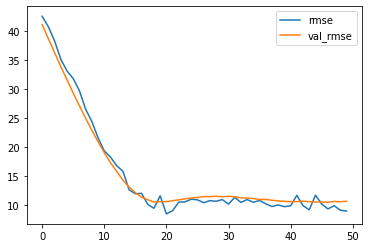

In [112]:
RMSE_COLS = ['rmse', 'val_rmse']

pd.DataFrame(history.history)[RMSE_COLS].plot()

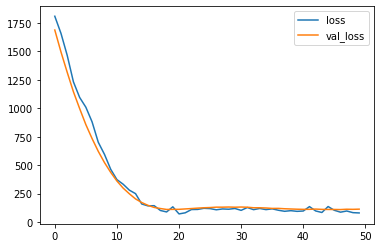

In [113]:
LOSS_COLS = ['loss', 'val_loss']

pd.DataFrame(history.history)[LOSS_COLS].plot()

## make predictions

In [114]:
model.predict(x={"pickup_longitude": tf.convert_to_tensor([-73.982683]),
                 "pickup_latitude": tf.convert_to_tensor([40.742104]),
                 "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
                 "dropoff_latitude": tf.convert_to_tensor([40.755174]),
                 "passenger_count": tf.convert_to_tensor([3.0])},
              steps=1)

array([[10.531947]], dtype=float32)

## save model to file - serialization

In [115]:
OUTPUT_DIR = "./export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR,
                           datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
tf.saved_model.save(model, EXPORT_PATH)  # with default serving function

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./export/savedmodel/20200903232058/assets


In [116]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir {EXPORT_PATH}
!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

2020-09-03 23:21:19.412731: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-09-03 23:21:19.412883: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-09-03 23:21:19.412905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
 

## Deploy

In [118]:
%%bash

# TODO 5a

PROJECT=canislatranscoxus
BUCKET=${PROJECT}
REGION=us-east1
MODEL_NAME=taxifare
VERSION_NAME=dnn

## Create GCS bucket if it doesn't exist already...
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
    echo -e "Bucket exists, let's not recreate it."
else
    echo "Creating a new GCS bucket."
    gsutil mb -l ${REGION} gs://${BUCKET}
    echo "\nHere are your current buckets:"
    gsutil ls
fi

if [[ $(gcloud ai-platform models list --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "$MODEL_NAME already exists"
else
    echo "Creating $MODEL_NAME"
    gcloud ai-platform models create --regions=$REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "
    echo yes | gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 2
fi

echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create --model=$MODEL_NAME $VERSION_NAME \
       --framework=tensorflow --python-version=3.7 --runtime-version=2.1 \
       --origin=$EXPORT_PATH --staging-bucket=gs://$BUCKET

Creating a new GCS bucket.
\nHere are your current buckets:
Creating taxifare
Creating taxifare:dnn


You are attempting to perform an operation that requires a project id, with none configured. Please re-run gsutil config and make sure to follow the instructions for finding and entering your default project id.
Creating gs://canislatranscoxus/...
You are attempting to perform an operation that requires a project id, with none configured. Please re-run gsutil config and make sure to follow the instructions for finding and entering your default project id.
You are attempting to perform an operation that requires a project id, with none configured. Please re-run gsutil config and make sure to follow the instructions for finding and entering your default project id.
Using endpoint [https://ml.googleapis.com/]
ERROR: (gcloud.ai-platform.models.list) You do not currently have an active account selected.
Please run:

  $ gcloud auth login

to obtain new credentials.

If you have already logged in with a different account:

    $ gcloud config set account ACCOUNT

to select an already authent

## load model from file

## references

### base notebook
https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/3_keras_sequential_api.ipynb


### upload files to colab
https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
